In [11]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.transforms import functional as TF
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet18_Weights
from tqdm import tqdm  # For progress bars
from PIL import ImageDraw

# Read Dataset

In [12]:
# Data directory
data_dir = "/kaggle/input/dog-and-cat-detection"
annotations_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

# Get list of image files and create a dummy dataframe to split the data
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
df = pd.DataFrame({'image_name': image_files})

df.head()

image_name
0  Cats_Test3283.png
1   Cats_Test727.png
2  Cats_Test1584.png
3  Cats_Test1196.png
4  Cats_Test2587.png

# Create PyTorch Dataset

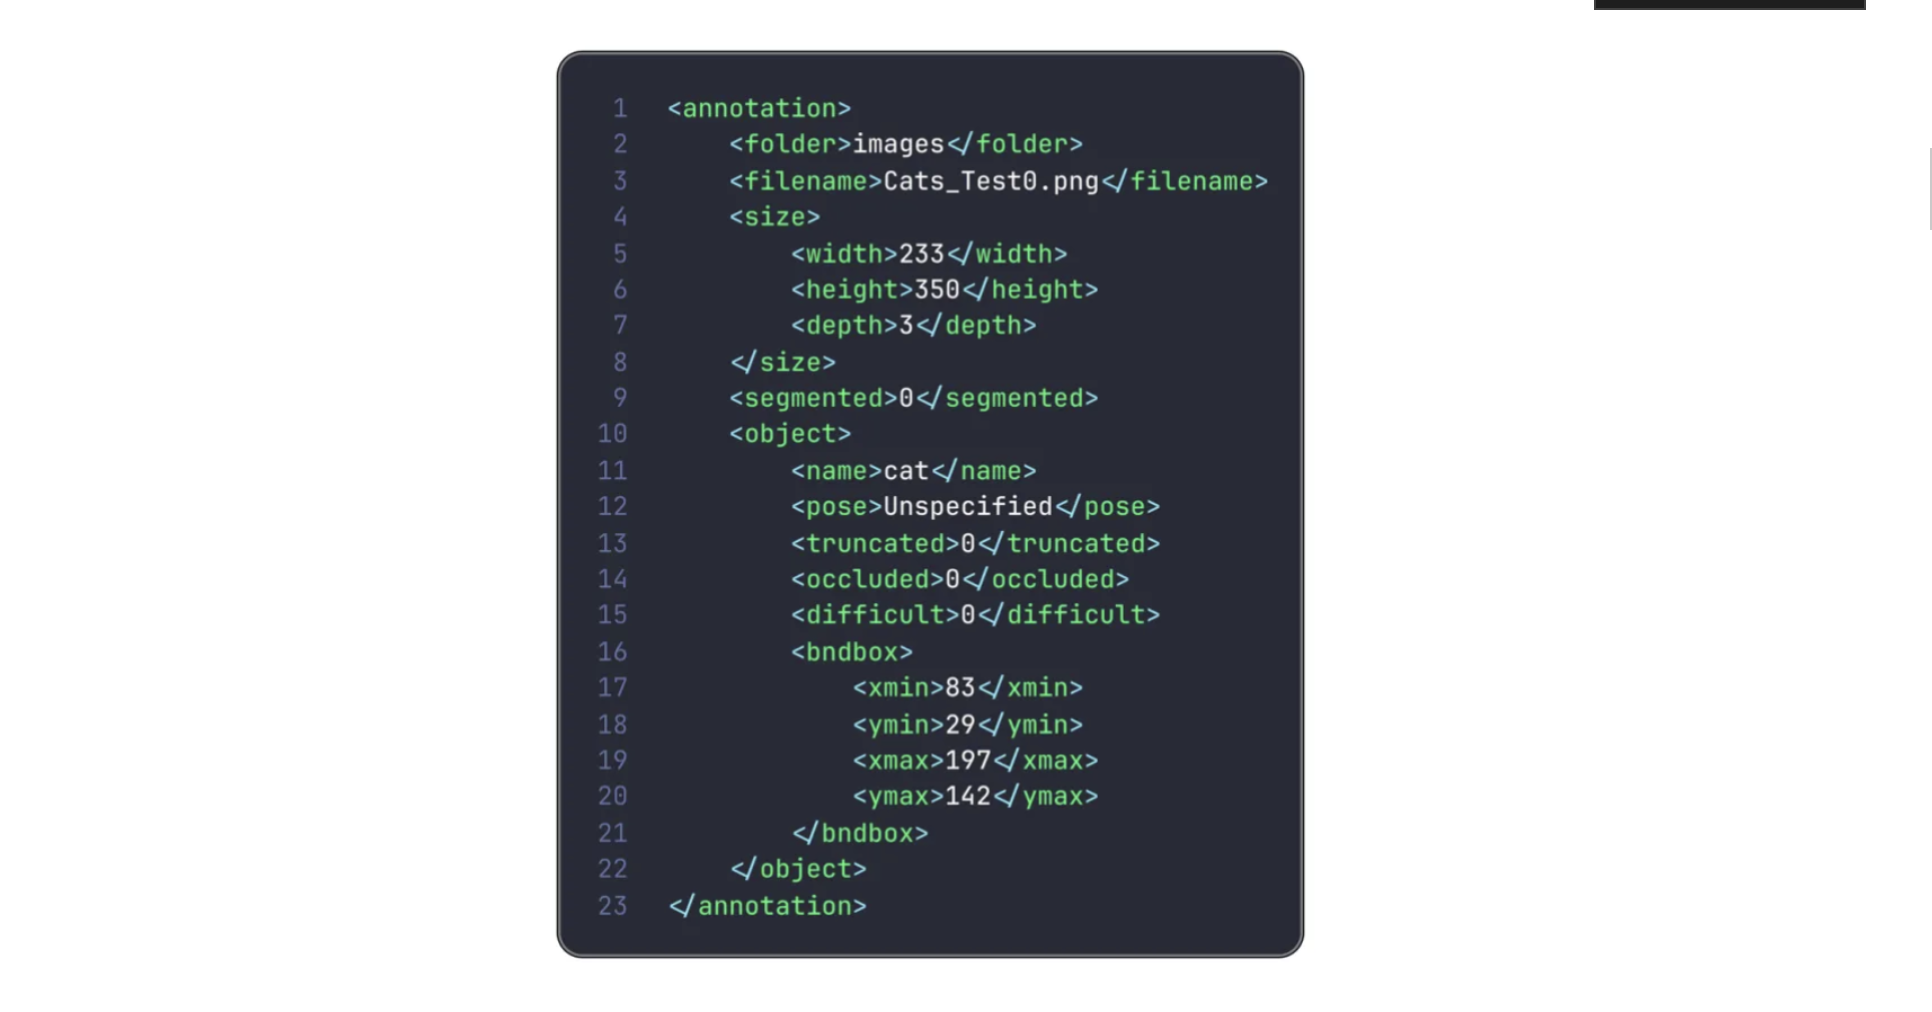

In [13]:
# Dataset Class
class ImageDataset(Dataset):
    def __init__(self, annotations_dir, image_dir, transform=None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects()

    def filter_images_with_multiple_objects(self):
        valid_image_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                img_name = f
                annotation_name = os.path.splitext(img_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotations_dir, annotation_name)

                if self.count_objects_in_annotation(annotation_path) <= 1:
                    valid_image_files.append(img_name)
                else:
                    print(
                        f"Image {img_name} has multiple objects and will be excluded from the dataset"
                    )
        return valid_image_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for obj in root.findall("object"):
                count += 1
            return count
        except FileNotFoundError:
            return 0

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Image path
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
    
        # Load image
        image = Image.open(img_path).convert("RGB")
    
        # Annotation path
        annotation_name = os.path.splitext(img_name)[0] + ".xml"
        annotation_path = os.path.join(self.annotations_dir, annotation_name)
    
        # Parse annotation
        label, bbox = self.parse_annotation(annotation_path)  # Get both label and bbox
    
        if self.transform:
            image = self.transform(image)
    
        return image, label, bbox

    
    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
    
        # Get image size for normalization
        image_width = int(root.find('size/width').text)
        image_height = int(root.find('size/height').text)
    
        label = None
        bbox = None
        for obj in root.findall('object'):
            name = obj.find('name').text
            if label is None:  # Take the first label
                label = name
                # Get bounding box coordinates
                xmin = int(obj.find('bndbox/xmin').text)
                ymin = int(obj.find('bndbox/ymin').text)
                xmax = int(obj.find('bndbox/xmax').text)
                ymax = int(obj.find('bndbox/ymax').text)
    
                # Normalize bbox coordinates to [0, 1]
                bbox = [
                    xmin / image_width,
                    ymin / image_height,
                    xmax / image_width,
                    ymax / image_height,
                ]
    
        # Convert label to numerical representation (0 for cat, 1 for dog)
        label_num = 0 if label == 'cat' else 1 if label == 'dog' else -1
    
        return label_num, torch.tensor(bbox, dtype=torch.float32)

In [14]:
# Split data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = ImageDataset(annotations_dir, image_dir, transform=transform)
val_dataset = ImageDataset(annotations_dir, image_dir, transform=transform)

# Filter datasets based on train_df and val_df
train_dataset.image_files = [f for f in train_dataset.image_files if f in train_df['image_name'].values]
val_dataset.image_files = [f for f in val_dataset.image_files if f in val_df['image_name'].values]

Image Cats_Test736.png has multiple objects and will be excluded from the dataset
Image Cats_Test736.png has multiple objects and will be excluded from the dataset


In [15]:
# Example: Check the shape of one training sample
img, label, bbox = train_dataset[0]
print("Training dataset length:", len(train_dataset))
print("Image shape:", img.shape)   # [C, H, W]
print("Label:", label)
print("BBox:", bbox)

# Example: Check the shape of one validation sample
img, label, bbox = val_dataset[0]
print("Validation dataset length:", len(val_dataset))
print("Image shape:", img.shape)   # [C, H, W]
print("Label:", label)
print("BBox:", bbox)

Training dataset length: 2947
Image shape: torch.Size([3, 224, 224])
Label: 0
BBox: tensor([0.1640, 0.1040, 0.5220, 0.5760])
Validation dataset length: 738
Image shape: torch.Size([3, 224, 224])
Label: 1
BBox: tensor([0.2246, 0.1140, 0.6856, 0.6300])


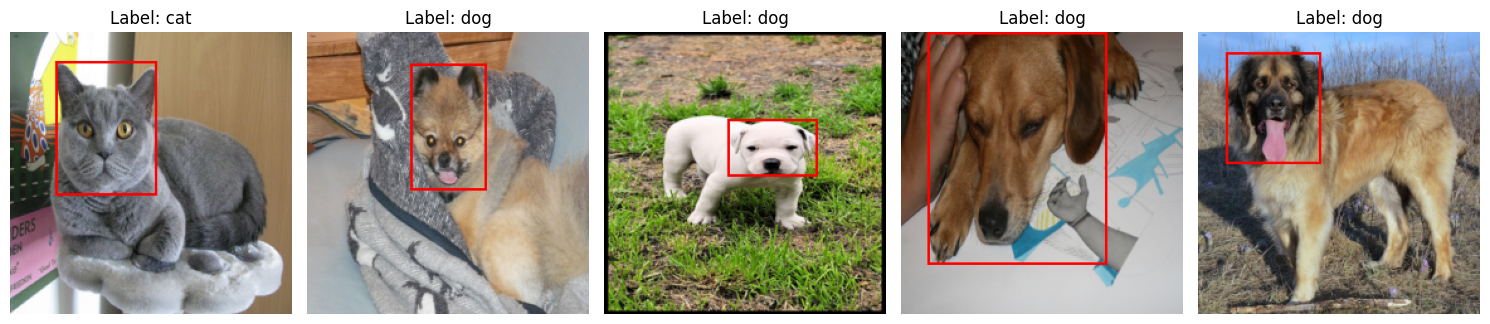

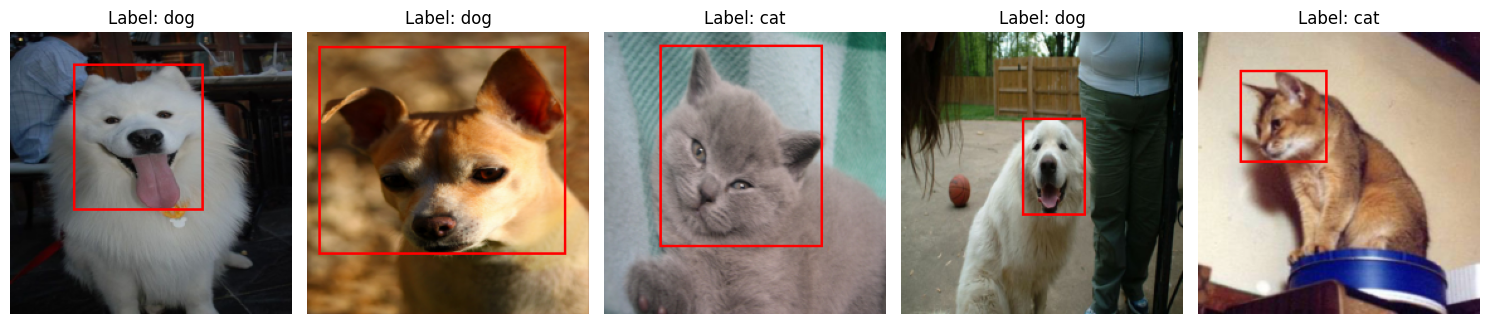

In [17]:
def denormalize(tensor, mean, std):
    """
    Denormalize a tensor image with mean and std.
    """
    mean = torch.tensor(mean).reshape(-1, 1, 1)
    std = torch.tensor(std).reshape(-1, 1, 1)
    return tensor * std + mean

def show_images(dataset, num_images=5, show_bbox=True):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        img, label, bbox = dataset[i]
        img = denormalize(img, mean, std)
        img = torch.clamp(img, 0, 1)
        img_pil = TF.to_pil_image(img)

        if show_bbox:
            draw = ImageDraw.Draw(img_pil)
            width, height = img_pil.size
            xmin = int(bbox[0] * width)
            ymin = int(bbox[1] * height)
            xmax = int(bbox[2] * width)
            ymax = int(bbox[3] * height)
            draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_pil)
        plt.title(f"Label: {'cat' if label == 0 else 'dog' if label == 1 else 'unknown'}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


show_images(train_dataset)
show_images(val_dataset)

# Create DataLoader

In [23]:
batch_size = 384

In [24]:
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [25]:
# Get one batch from the train loader
for images, labels, bboxes in train_loader:
    print("Train batch - images shape:", images.shape)    # [B, C, H, W]
    print("Train batch - labels shape:", labels.shape)    # [B]
    print("Train batch - bboxes shape:", bboxes.shape)    # [B, 4]
    break  # Only print first batch

# Get one batch from the val loader
for images, labels, bboxes in val_loader:
    print("Val batch - images shape:", images.shape)
    print("Val batch - labels shape:", labels.shape)
    print("Val batch - bboxes shape:", bboxes.shape)
    break

Train batch - images shape: torch.Size([384, 3, 224, 224])
Train batch - labels shape: torch.Size([384])
Train batch - bboxes shape: torch.Size([384, 4])
Val batch - images shape: torch.Size([384, 3, 224, 224])
Val batch - labels shape: torch.Size([384])
Val batch - bboxes shape: torch.Size([384, 4])


# Create Model

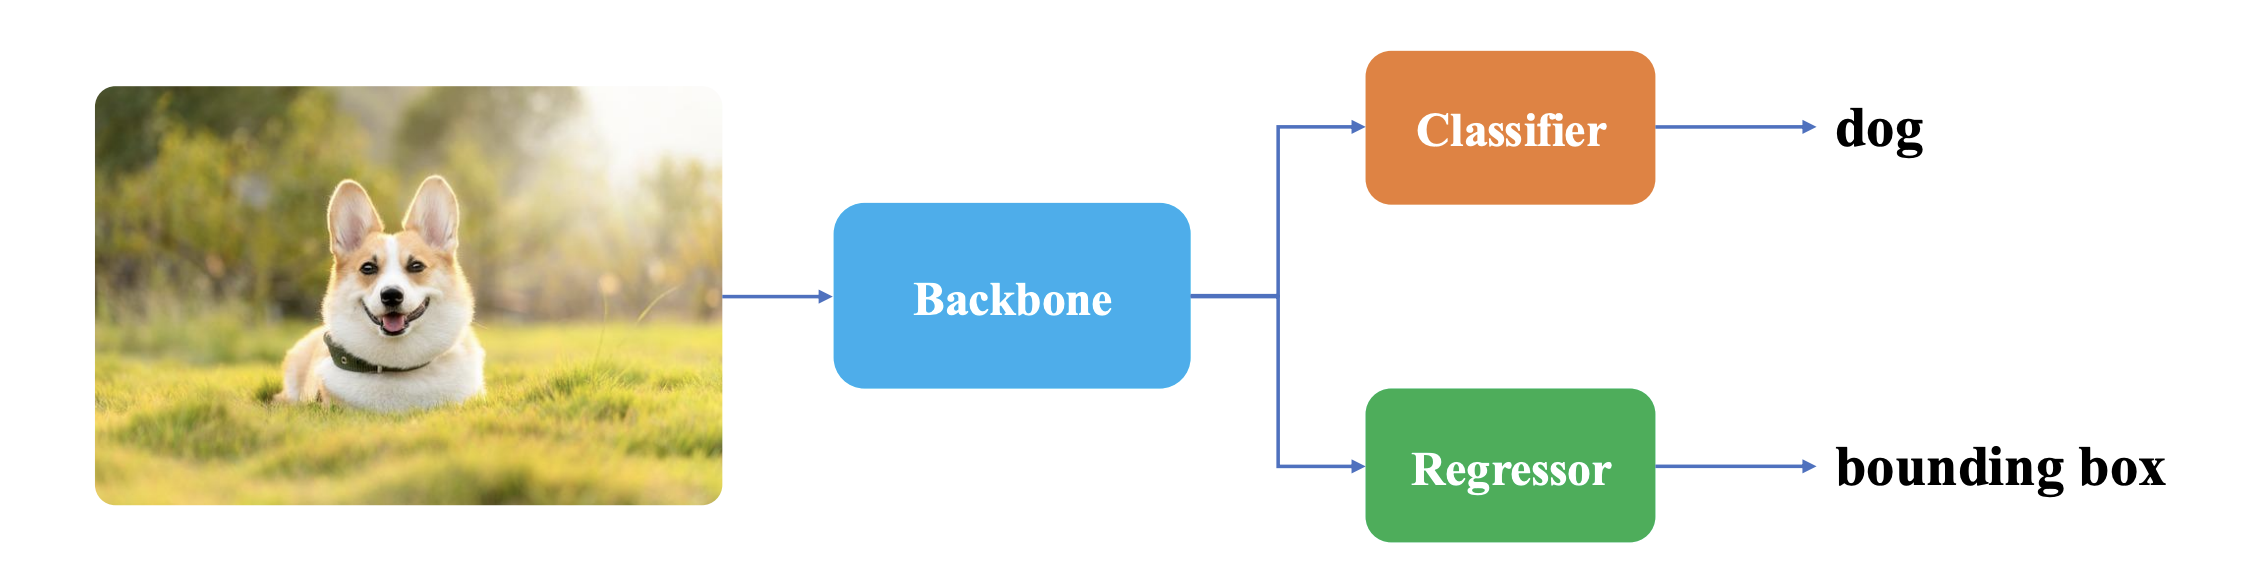

In [26]:
# Model with Two Heads
class TwoHeadedModel(nn.Module):
    def __init__(self, num_classes=2):
        super(TwoHeadedModel, self).__init__()
        self.base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.num_ftrs = self.base_model.fc.in_features

        # Remove the original fully connected layer
        self.base_model.fc = nn.Identity()

        # Classification head
        self.classifier = nn.Linear(self.num_ftrs, num_classes)

        # Bounding box regression head
        self.regressor = nn.Linear(self.num_ftrs, 4)

    def forward(self, x):
        x = self.base_model(x)
        class_logits = self.classifier(x)
        bbox_coords = torch.sigmoid(self.regressor(x))
        return class_logits, bbox_coords


In [27]:
# Model
model = TwoHeadedModel()

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion_class = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 219MB/s]


# Training and Evaluation

In [28]:
# Training Loop
num_epochs = 10
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    for batch_idx, (data, targets, bboxes) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        data = data.to(device)
        targets = targets.to(device)
        bboxes = bboxes.to(device)

        scores, pred_bboxes = model(data)
        loss_class = criterion_class(scores, targets)
        loss_bbox = criterion_bbox(pred_bboxes, bboxes)
        loss = loss_class + loss_bbox  # Combine losses

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        r2_list = []
    
        for data, targets, bboxes in tqdm(val_loader, desc="Validation", leave=False):
            data = data.to(device)
            targets = targets.to(device)
            bboxes = bboxes.to(device)
    
            scores, pred_bboxes = model(data)
            _, predictions = scores.max(1)
            correct += (predictions == targets).sum()
            total += targets.size(0)
    
            # Compute R² for this batch
            pred_bboxes_flat = pred_bboxes.view(pred_bboxes.size(0), -1)
            bboxes_flat = bboxes.view(bboxes.size(0), -1)
    
            ss_res = torch.sum((pred_bboxes_flat - bboxes_flat) ** 2, dim=0)
            ss_tot = torch.sum((bboxes_flat - bboxes_flat.mean(dim=0)) ** 2, dim=0)
    
            # Avoid division by zero in degenerate cases
            ss_tot[ss_tot == 0] = 1e-6
    
            r2 = 1 - ss_res / ss_tot
            r2_batch = r2.mean().item()
            r2_list.append(r2_batch)
    
        r2_mean = sum(r2_list) / len(r2_list)
        acc_mean = float(correct) / float(total)
    
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {acc_mean*100:.2f}%,'\
              f'BBox R²: {r2_mean:.4f}')

Training: 100%|██████████| 8/8 [00:39<00:00,  4.37s/it]
                                                       
Epochs:  10%|█         | 1/10 [00:48<07:13, 48.21s/it]   

Epoch 1/10, Validation Accuracy: 95.12%,BBox R²: -1.0171



Training: 100%|██████████| 8/8 [00:28<00:00,  3.32s/it]
                                                       
Epochs:  20%|██        | 2/10 [01:24<05:28, 41.02s/it]   

Epoch 2/10, Validation Accuracy: 87.80%,BBox R²: -0.1237



Training: 100%|██████████| 8/8 [00:28<00:00,  3.35s/it]
                                                       
Epochs:  30%|███       | 3/10 [02:00<04:30, 38.70s/it]   

Epoch 3/10, Validation Accuracy: 97.15%,BBox R²: -0.1362



Training: 100%|██████████| 8/8 [00:28<00:00,  3.30s/it]
                                                       
Epochs:  40%|████      | 4/10 [02:35<03:45, 37.56s/it]   

Epoch 4/10, Validation Accuracy: 96.88%,BBox R²: 0.2727



Training: 100%|██████████| 8/8 [00:27<00:00,  3.26s/it]
                                                       
Epochs:  50%|█████     | 5/10 [03:11<03:04, 36.81s/it]   

Epoch 5/10, Validation Accuracy: 94.31%,BBox R²: 0.3702



Training: 100%|██████████| 8/8 [00:28<00:00,  3.30s/it]
                                                       
Epochs:  60%|██████    | 6/10 [03:47<02:25, 36.45s/it]   

Epoch 6/10, Validation Accuracy: 97.29%,BBox R²: 0.4807



Training: 100%|██████████| 8/8 [00:28<00:00,  3.34s/it]
                                                       
Epochs:  70%|███████   | 7/10 [04:23<01:49, 36.34s/it]   

Epoch 7/10, Validation Accuracy: 97.97%,BBox R²: 0.5467



Training: 100%|██████████| 8/8 [00:28<00:00,  3.31s/it]
                                                       
Epochs:  80%|████████  | 8/10 [04:59<01:12, 36.23s/it]   

Epoch 8/10, Validation Accuracy: 98.24%,BBox R²: 0.6285



Training: 100%|██████████| 8/8 [00:28<00:00,  3.34s/it]
                                                       
Epochs:  90%|█████████ | 9/10 [05:35<00:36, 36.07s/it]   

Epoch 9/10, Validation Accuracy: 98.37%,BBox R²: 0.6826



Training: 100%|██████████| 8/8 [00:28<00:00,  3.31s/it]
                                                       
Epochs: 100%|██████████| 10/10 [06:10<00:00, 37.05s/it]  

Epoch 10/10, Validation Accuracy: 98.51%,BBox R²: 0.7131


# Inference

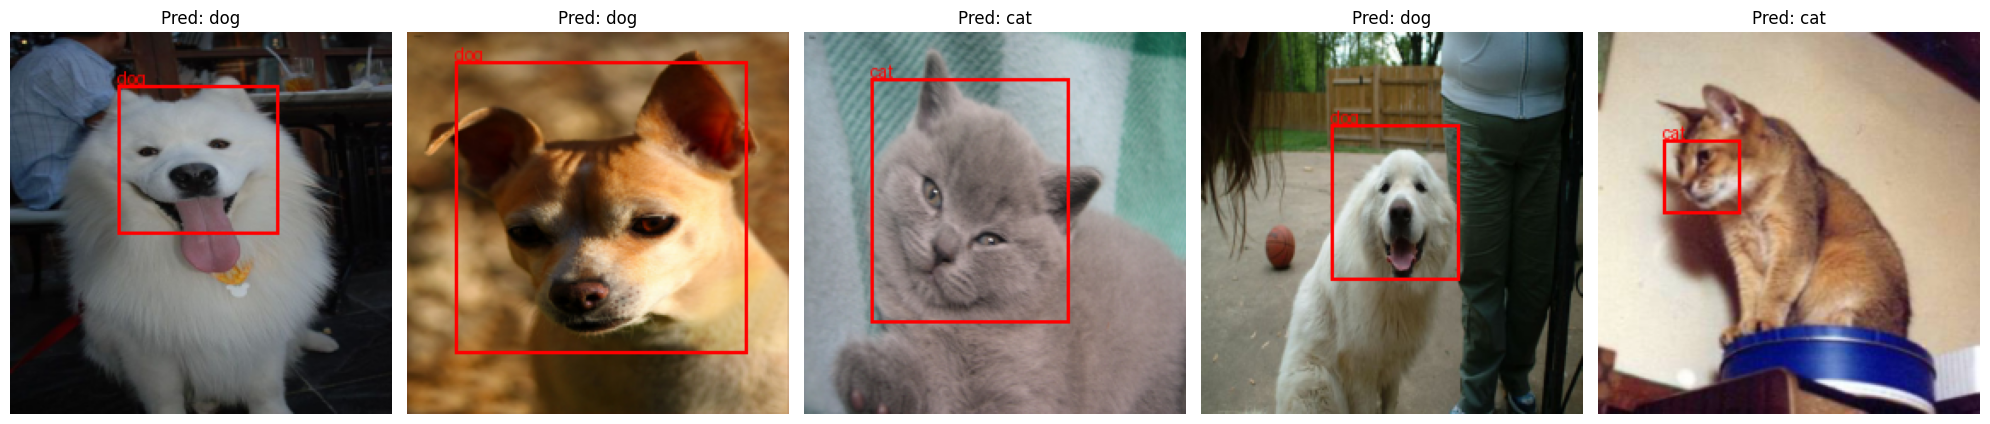

In [29]:
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
from PIL import ImageDraw, ImageFont
import torch.nn.functional as F

# Ensure model is in eval mode
model.eval()

# Class label mapping
idx_to_class = {0: 'cat', 1: 'dog'}

# Mean and std used in transforms (for denormalization)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).reshape(-1, 1, 1)
    std = torch.tensor(std).reshape(-1, 1, 1)
    return tensor * std + mean

# Inference on 5 validation images
plt.figure(figsize=(20, 8))
for i in range(5):
    image, _, _ = val_dataset[i]  # Get image only (label and gt bbox are not needed here)
    input_tensor = image.unsqueeze(0).to(device)  # Add batch dim and move to device

    with torch.no_grad():
        class_logits, pred_bbox = model(input_tensor)
        pred_class = class_logits.argmax(dim=1).item()
        pred_bbox = pred_bbox.squeeze().cpu().numpy()  # [xmin, ymin, xmax, ymax], normalized

    # Denormalize and convert to PIL
    image = denormalize(image, mean, std)
    image = torch.clamp(image, 0, 1)
    img_pil = TF.to_pil_image(image)

    # Draw bbox
    draw = ImageDraw.Draw(img_pil)
    W, H = img_pil.size
    xmin = int(pred_bbox[0] * W)
    ymin = int(pred_bbox[1] * H)
    xmax = int(pred_bbox[2] * W)
    ymax = int(pred_bbox[3] * H)

    draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
    draw.text((xmin, ymin - 10), idx_to_class.get(pred_class, "unknown"), fill="red")

    # Show image
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_pil)
    plt.title(f"Pred: {idx_to_class[pred_class]}")
    plt.axis("off")

plt.tight_layout()
plt.show()
